In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F

import wandb
import os

from sklearn.decomposition import PCA

import GPUtil

# Loading Data:
---

In [2]:
file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/train_data.csv'
train = pd.read_csv(file_path)
file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/val_data.csv'
val = pd.read_csv(file_path)
file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/test_data.csv'
test = pd.read_csv(file_path)


file_path = '../data/name_smiles_embedding_file.csv'
name_smiles_embedding_df = pd.read_csv(file_path)

In [3]:
train.head()

,Unnamed: 0,index,p_184,p_185,p_186,p_187,p_188,p_189,p_190,p_191,...,n_1021,Label,DEB,DEM,DMMP,DPM,DtBP,JP8,MES,TEPO
0,313556,1419264,136.0,142.0,147.0,153.0,159.0,166.0,171.0,179.0,...,-7.0,TEPO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,177622,1074499,73.0,77.0,82.0,88.0,94.0,99.0,103.0,106.0,...,-13.0,DtBP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,264630,1271546,84.0,87.0,91.0,96.0,100.0,105.0,110.0,115.0,...,-7.0,DMMP,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,253651,1243128,103.0,107.0,111.0,113.0,117.0,121.0,126.0,130.0,...,10.0,DMMP,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,66372,434047,86.0,88.0,90.0,93.0,97.0,102.0,106.0,111.0,...,-6.0,MES,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [4]:
train.columns[-8:]

Index(['DEB', 'DEM', 'DMMP', 'DPM', 'DtBP', 'JP8', 'MES', 'TEPO'], dtype='object')

In [5]:
name_smiles_embedding_df.head()

,Unnamed: 0,Name,SMILES,embedding
0,BKG,background,NaN,NaN
1,DEM,Diethyl Malonate,CCOC(=O)CC(=O)OCC,"[0.3809721, 0.0005454041, 0.25539744, -0.24272..."
2,DEB,"1,2,3,4-Diepoxybutane",C1C(O1)C2CO2,"[0.06318794, 0.009022224, 0.42160064, 0.195722..."
3,MES,2-(N-morpholino)ethanesulfonic acid,C1COCCN1CCS(=O)(=O)O,"[-0.32520828, 0.009838344, -0.15108332, 0.2845..."
4,DMMP,Dimethyl methylphosphonate,COP(=O)(C)OC,"[0.12106811, 0.00294244, -0.14450458, 0.072665..."


In [6]:
# set the df index to be the chemical abbreviations in col 'Unnamed: 0'
name_smiles_embedding_df.set_index('Unnamed: 0', inplace=True)
name_smiles_embedding_df.head()

,Name,SMILES,embedding
Unnamed: 0,,,
BKG,background,NaN,NaN
DEM,Diethyl Malonate,CCOC(=O)CC(=O)OCC,"[0.3809721, 0.0005454041, 0.25539744, -0.24272..."
DEB,"1,2,3,4-Diepoxybutane",C1C(O1)C2CO2,"[0.06318794, 0.009022224, 0.42160064, 0.195722..."
MES,2-(N-morpholino)ethanesulfonic acid,C1COCCN1CCS(=O)(=O)O,"[-0.32520828, 0.009838344, -0.15108332, 0.2845..."
DMMP,Dimethyl methylphosphonate,COP(=O)(C)OC,"[0.12106811, 0.00294244, -0.14450458, 0.072665..."


In [7]:
name_smiles_embedding_df['SMILES']['DEM']

# name_smiles_embedding_df.head()

'CCOC(=O)CC(=O)OCC'

Determining the highest non-zero index for each of the samples. Each row is currently two spectra (p and n). Looking at the highest non-zero index across all spectra.

It might make sense to cut the spectra down a bit. Currently they seem to have long tails that I don't believe are important for identification? 

In [8]:
p_vals = [int(col.split('_')[1]) for col in train.columns if col.split('_')[0] == 'p']
n_vals = [int(col.split('_')[1]) for col in train.columns if col.split('_')[0] == 'n']

# indexing 2:len(p_vals)+2 because first two rows are not p_vals
# highest_p = train.iloc[:, 2:len(p_vals)+2].apply(
#     lambda row: row.iloc[::-1].ne(0).idxmax() if row.ne(0).any() else None, axis=1
# )

# indexing 2:len(p_vals)+2 because first two rows are not p_vals
# getting index of highest > threshold entry in each row. 
threshold = 20
highest_p = train.iloc[:, 2:len(p_vals)+2].apply(
    lambda row: row.iloc[::-1].gt(threshold).idxmax() if row.gt(threshold).any() else None, axis=1
)
print(highest_p)


0         p_618
1         p_444
2         p_432
3         p_424
4         p_460
          ...  
267017    p_392
267018    p_646
267019    p_385
267020    p_454
267021    p_536
Length: 267022, dtype: object


# Definitions:
---

In [23]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
      # nn.Linear(1676,1300),
      # nn.LeakyReLU(inplace=True),
      # nn.Linear(1300,1000),
      # nn.LeakyReLU(inplace=True),
      # nn.Linear(1000,700),
      # nn.LeakyReLU(inplace=True),
      # nn.Linear(700,512),
      nn.Linear(1676,1548),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1548,1420),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1420, 1292),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1292, 1164),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1164, 1036),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1036, 908),
      nn.LeakyReLU(inplace=True),
      nn.Linear(908, 780),
      nn.LeakyReLU(inplace=True),
      nn.Linear(780, 652),
      nn.LeakyReLU(inplace=True),
      nn.Linear(652, 512),
    )

  def forward(self, x):
    x = self.encoder(x)
    return x

In [24]:
def run_with_wandb(config, **kwargs):
    config.update(kwargs)

    wandb.init(entity=config['wandb_entity'],
               project=config['wandb_project'],
               config=config)

    # Set the number of threads
    torch.set_num_threads(config['threads'])

    # Find out is there is a GPU available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if not config['gpu']:
        device = torch.device('cpu')
    print(f'Using device: {device}')

In [25]:
def plot_emb_pca(all_embeddings, all_chemical_names, output_embeddings, output_labels):
    """
    Run pca on embeddings from denoiser output. Plot results against PCA of Chemception embeddings.

    Parameters:
    - all_embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
    - all_chemical_names (list): Sorted list of all chemical names in the training data.
    - output_embeddings (list): Encoder output embeddings.
    - output_labels (list): Chemical names for each embedding in the encoder's output.
    """

    pca = PCA(n_components=2)
    pca.fit(all_embeddings.T)

    # Extract true embeddings for all chemicals and transform them using the fitted PCA
    true_embeddings = [all_embeddings[chem] for chem in all_chemical_names]
    true_transformed = pca.transform(true_embeddings)

    # Transform the encoder output embeddings using the same PCA
    output_embeddings = np.array([emb.detach().numpy() for emb in output_embeddings])
    output_transformed = pca.transform(np.array(output_embeddings))

    # Create a color map where each chemical name is assigned a unique integer
    color_map = {chem: idx for idx, chem in enumerate(all_chemical_names)}

    # Map chemical names to their respective colors for the true embeddings
    true_colors = [color_map[chem] for chem in all_chemical_names]
    # Map chemical names to their respective colors for the output embeddings
    output_colors = [color_map[chem] for chem in output_labels]

    # Extract the x and y coordinates from the transformed true embeddings
    true_x = [pair[0] for pair in true_transformed]
    true_y = [pair[1] for pair in true_transformed]
    # Extract the x and y coordinates from the transformed true embeddings
    scatter = plt.scatter(true_x, true_y, c=true_colors, cmap='tab20')

    # Extract the x and y coordinates from the transformed output embeddings
    output_x = [pair[0] for pair in output_transformed]
    output_y = [pair[1] for pair in output_transformed]
    # Create a scatter plot for the output embeddings
    plt.scatter(output_x, output_y, marker='x', c=output_colors, cmap='tab20')

    # Add a legend to the plot
    plt.legend(handles=scatter.legend_elements()[0],
                labels=all_chemical_names,
                loc='upper right',
                prop={'size':7})


    plt.title('Chemception Embeddings vs. Encoder Output', fontsize=18)
    plt.xticks([])
    plt.yticks([])

    plt.show()

# Setting up Datasets
---

## Setting up GPU:
---

In [13]:
if torch.cuda.is_available():
    # Get the list of GPUs
    gpus = GPUtil.getGPUs()

    # Find the GPU with the most free memory
    best_gpu = max(gpus, key=lambda gpu: gpu.memoryFree)

    # Print details about the selected GPU
    print(f"Selected GPU ID: {best_gpu.id}")
    print(f"  Name: {best_gpu.name}")
    print(f"  Memory Free: {best_gpu.memoryFree} MB")
    print(f"  Memory Used: {best_gpu.memoryUsed} MB")
    print(f"  GPU Load: {best_gpu.load * 100:.2f}%")

    # Set the device for later use
    device = torch.device(f'cuda:{best_gpu.id}')
    print('Current device ID: ', device)

    # Set the current device in PyTorch
    torch.cuda.set_device(best_gpu.id)
else:
    device = torch.device('cpu')
    print('Using CPU')

# Confirm the currently selected device in PyTorch
print("PyTorch current device ID:", torch.cuda.current_device())
print("PyTorch current device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Selected GPU ID: 1
  Name: NVIDIA GeForce RTX 4090
  Memory Free: 23815.0 MB
  Memory Used: 401.0 MB
  GPU Load: 0.00%
Current device ID:  cuda:1
PyTorch current device ID: 1
PyTorch current device name: NVIDIA GeForce RTX 4090


## Creating Dataloader Objects:
---

In [6]:
name_smiles_embedding_df.head()

,Unnamed: 0,Name,SMILES,embedding
0,BKG,background,NaN,NaN
1,DEM,Diethyl Malonate,CCOC(=O)CC(=O)OCC,"[0.3809721, 0.0005454041, 0.25539744, -0.24272..."
2,DEB,"1,2,3,4-Diepoxybutane",C1C(O1)C2CO2,"[0.06318794, 0.009022224, 0.42160064, 0.195722..."
3,MES,2-(N-morpholino)ethanesulfonic acid,C1COCCN1CCS(=O)(=O)O,"[-0.32520828, 0.009838344, -0.15108332, 0.2845..."
4,DMMP,Dimethyl methylphosphonate,COP(=O)(C)OC,"[0.12106811, 0.00294244, -0.14450458, 0.072665..."


Currently embeddings are strings instead of a list of floats. Would be good to fix that in preprocessing.

In [15]:
embedding_floats = []
for chem_name in name_smiles_embedding_df.index:
    if chem_name == 'BKG':
        embedding_floats.append(None)
    else:
        embedding_float = name_smiles_embedding_df['embedding'][chem_name].split('[')[1]
        embedding_float = embedding_float.split(']')[0]
        embedding_float = [np.float32(num) for num in embedding_float.split(',')]
        embedding_floats.append(embedding_float)

name_smiles_embedding_df['Embedding Floats'] = embedding_floats

In [16]:
# drop first two cols ('Unnamed:0' and 'index') and last 9 cols ('Label' and OneHot encodings) to get just spectra
train_spectra = train.iloc[:,2:-9]
train_chem_encodings = train.iloc[:,-8:]

In [17]:
train_chem_labels = list(train['Label'])
train_embeddings_tensor = torch.Tensor([name_smiles_embedding_df['Embedding Floats'][chem_name] for chem_name in train_chem_labels]).to(device)
train_spectra_tensor = torch.Tensor(train_spectra.values).to(device)
train_chem_encodings_tensor = torch.Tensor(train_chem_encodings.values).to(device)

batch_size = 128
train_dataset = DataLoader(TensorDataset(train_spectra_tensor, train_chem_encodings_tensor, train_embeddings_tensor), batch_size=batch_size, shuffle=True)

# Train Encoder:
---

In [26]:
# os.environ['WANDB_API_KEY'] = '9729ad7b1f3a60f1072cdf7af979b737955733d4'
config = {
    'wandb_entity': 'catemerfeld',
    'wandb_project': 'ims_encoder_decoder',
    'gpu':True,
    'threads':1,
}

os.environ['WANDB_NOTEBOOK_NAME'] = '/home/cmdunham/ChemicalDataGeneration/models/ims_encoder.ipynb'

In [20]:
# Get the allocated memory on the GPU
allocated_memory = torch.cuda.memory_allocated(device) / (1024 ** 2)  # in MB
cached_memory = torch.cuda.memory_reserved(device) / (1024 ** 2)  # in MB

print(f"Allocated Memory: {allocated_memory:.2f} MB")
print(f"Cached Memory: {cached_memory:.2f} MB")

Allocated Memory: 2238.15 MB
Cached Memory: 2250.00 MB


In [21]:
gpus = GPUtil.getGPUs()
for gpu in gpus:
    print(torch.cuda.get_device_name(gpu))
    print(f"GPU ID: {gpu.id}, Memory Free: {round(gpu.memoryFree):,} MB, Memory Used: {round(gpu.memoryUsed):,} MB, Memory Total: {round(gpu.memoryTotal):,} MB")
    print(f"GPU ID: {gpu.id}, percent of total memory free: {round(gpu.memoryFree/gpu.memoryTotal, 2)*100}%")
    print('---------------------------------------------------------------------------------')

NVIDIA GeForce RTX 4090
GPU ID: 0, Memory Free: 2,674 MB, Memory Used: 21,542 MB, Memory Total: 24,564 MB
GPU ID: 0, percent of total memory free: 11.0%
---------------------------------------------------------------------------------
NVIDIA GeForce RTX 4090
GPU ID: 1, Memory Free: 21,565 MB, Memory Used: 2,651 MB, Memory Total: 24,564 MB
GPU ID: 1, percent of total memory free: 88.0%
---------------------------------------------------------------------------------


In [41]:
def preds_to_emb_pca_plot(predicted_embeddings, output_name_encodings, sorted_chem_names, emb_df):
    """
    Generate and plot a PCA visualization of predicted embeddings against corresponding Chemception embeddings.

    Parameters:
    ----------
    predicted_embeddings : list of list of torch.Tensor
        A nested list of predicted embeddings, where each inner list contains tensors for a batch.

    output_name_encodings : list of list of torch.Tensor
        A nested list of one-hot encoded tensors representing the chemical names for the predicted embeddings.

    sorted_chem_names : list of str
        A list of chemical names corresponding to the indices of the one-hot encodings.

    emb_df : pandas.DataFrame
        A DataFrame containing true embeddings, with 'Embedding Floats' as one of its columns.

    Returns:
    -------
    A tuple containing:
    - true_embeddings (pd.DataFrame): DataFrame of true embeddings used for comparison.
    - predicted_embeddings_flattened (list): Flattened list of predicted embeddings.
    - chem_names (list): List of chemical names corresponding to the predicted embeddings.
    """

    # Currently, preds and name encodings are lists of [n_batches, batch_size], flattening to lists of [n_samples]
    predicted_embeddings_flattened = [emb.cpu() for emb_list in predicted_embeddings for emb in emb_list]
    chem_name_encodings_flattened = [enc.cpu() for enc_list in output_name_encodings for enc in enc_list]
    # Get chemical names from encodings
    chem_names = [sorted_chem_names[list(encoding).index(1)] for encoding in chem_name_encodings_flattened]

    # making list of all embeddings and chem names except for BKG
    embeddings = [emb for emb in emb_df['Embedding Floats']][1:]
    cols = emb_df.index[1:]
    true_embeddings = pd.DataFrame(embeddings).T
    true_embeddings.columns = cols

    plot_emb_pca(true_embeddings, list(emb_df.index)[1:], predicted_embeddings_flattened, chem_names)

    return (true_embeddings, predicted_embeddings_flattened, chem_names)

Using device: cuda
Epoch[1/20], loss: 1.0818641644204219e-05
-------------------------------------------
Epoch[2/20], loss: 5.481809098993616e-06
-------------------------------------------
Epoch[3/20], loss: 4.157906746754187e-06
-------------------------------------------
Epoch[4/20], loss: 3.620403102380474e-06
-------------------------------------------
Epoch[5/20], loss: 3.0989311978548897e-06
-------------------------------------------
Epoch[6/20], loss: 5.1433145529466235e-06
-------------------------------------------
Epoch[7/20], loss: 3.2489820987970493e-06
-------------------------------------------
Epoch[8/20], loss: 4.29154613246506e-06
-------------------------------------------
Epoch[9/20], loss: 2.1731959324434373e-06
-------------------------------------------
Epoch[10/20], loss: 3.354093650552601e-06
-------------------------------------------
Epoch[11/20], loss: 2.4580311305561505e-06
-------------------------------------------
Epoch[12/20], loss: 3.511431086353822e-

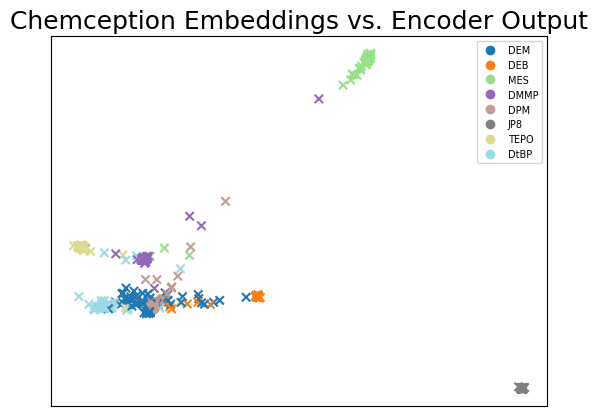

Encoder Training Loss,█▄▃▂▂▄▂▃▁▂▂▂▂▁▁▂▃▂▁▆
Encoder Training Loss,1e-05


In [39]:
# set var deciding if embedding pca plot for this run is saved to wandb
save_emb_pca_to_wandb = True

# Last 8 cols of the df are the chem names
sorted_chem_names = list(train.columns[-8:])

epochs = 20
learning_rate = .00001
# encoder = Encoder().to(device)

encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr = learning_rate)
encoder_criterion = nn.MSELoss()

predicted_embeddings = []
output_chem_names = []
output_name_encodings = []

wandb_kwargs = {
    'learning_rate': learning_rate,
    'epochs': epochs,
    'batch_size': batch_size,
    'model_architecture': 'encoder',
    'optimizer':'AdamW',
    'loss': 'MSELoss'
}

run_with_wandb(config, **wandb_kwargs)

for epoch in range(epochs):
  # accumulate epoch loss
  epoch_training_loss = 0
  gpus = GPUtil.getGPUs()
  # for gpu in gpus:
  #     print(f"GPU ID: {gpu.id}, percent of total memory used: {round(gpu.memoryUsed/gpu.memoryTotal, 2)*100}%")

  for batch, name_encodings, true_embeddings in train_dataset:
    # move inputs to device
    batch = batch.to(device)
    name_encodings = name_encodings.to(device)
    true_embeddings = true_embeddings.to(device)

    # forward pass
    batch_predicted_embeddings = encoder(batch)

    loss = encoder_criterion(batch_predicted_embeddings, true_embeddings)
    epoch_training_loss += loss.item()

    # backprapogation
    encoder_optimizer.zero_grad()
    loss.backward()
    encoder_optimizer.step()

    # at last epoch store output embeddings and corresponding labels to output list
    if (epoch + 1) == epochs:
      output_name_encodings.append(name_encodings)
      predicted_embeddings.append(batch_predicted_embeddings)

  average_loss = epoch_training_loss/len(train_dataset)
  wandb.log({"Encoder Training Loss": average_loss})

  if (epoch + 1) % 1 == 0:
    print('Epoch[{}/{}], loss: {}'.format(epoch+1, epochs, average_loss))
    print('-------------------------------------------')

if save_emb_pca_to_wandb:
  true_embeddings, predicted_embeddings_flattened, chem_names = preds_to_emb_pca_plot(predicted_embeddings, output_name_encodings, sorted_chem_names, name_smiles_embedding_df)

wandb.finish()


  # # NEEDS to be updated for gpu
  # ------------------------------
  # encoder.eval() # Set model to evaluation mode
  # epoch_val_loss = 0
  # with torch.no_grad():
  #   for batch, name_encodings, true_embeddings in val_dataset:
  #     batch_predicted_embeddings = encoder(batch)

  #     loss = encoder_criterion(batch_predicted_embeddings, true_embeddings)
  #     epoch_test_loss += loss.item()

  # # Set models back to training mode
  # encoder.train()
  # val_average_loss = epoch_test_loss/len(val_dataset)
  # wandb.log({"Encoder Validation Loss": val_average_loss})
  # wandb.log({"Encoder Validation Loss": val_average_loss})
  # print('Test loss: {:.4f}'.format(test_average_loss))

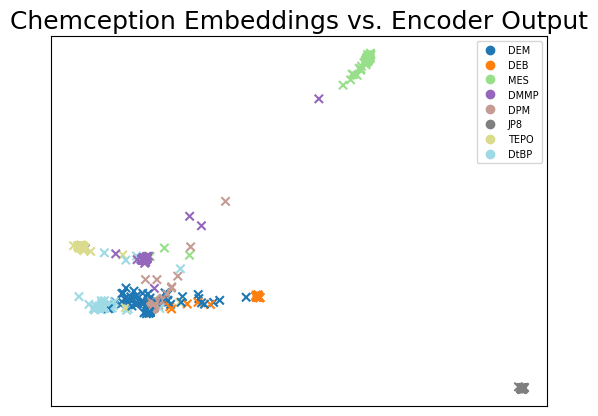

In [42]:
plot_emb_pca(true_embeddings, list(name_smiles_embedding_df.index)[1:], predicted_embeddings_flattened, chem_names)

Best results so far from training first w/lr=.0001 then w/lr=.00001

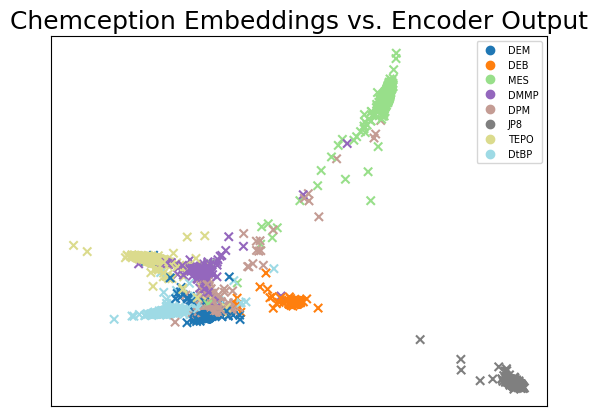

In [31]:
plot_emb_pca(true_embeddings, list(name_smiles_embedding_df.index)[1:], predicted_embeddings_flattened, chem_names)